In [66]:
import festim as F

In [67]:
# --- Parameters (numerical) --- unused as of now
D1 = 6e-11           # inconel
D2 = 1.54e-11        # 316L steel
x0 = 0.0
xint = 0.5
L = 1.0
P = 1e5

Kd1 = 3e13
Kr1 = 2.68e-30
Kd2 = 8e11
Kr2 = 2.4e-33

S1 = float((Kd1 / Kr1) ** 0.5)
S2 = float((Kd2 / Kr2) ** 0.5)

In [68]:
my_model = F.Simulation()

In [69]:
barrier_thick = 0.01
substrate_thick = 0.01

barrier = F.Material(
    id=1,
    D_0=1e-8,
    E_D=0.39,
    S_0=1e22,
    E_S=1.04,
    borders=[0, barrier_thick]
    )

# tungsten
substrate = F.Material(
    id=2,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    borders=[barrier_thick, substrate_thick + barrier_thick]
    )

my_model.materials = [barrier, substrate]

In [70]:
import numpy as np

vertices_barrier = np.linspace(0, barrier_thick, num=200)

vertices_substrate = np.linspace(
    barrier_thick, substrate_thick + barrier_thick, num=200)

vertices = np.concatenate([vertices_barrier, vertices_substrate])

my_model.mesh = F.MeshFromVertices(vertices)

In [71]:
my_model.T = 500
P_up = 100  # Pa

left_bc = F.SievertsBC(
    surfaces=1,
    S_0=barrier.S_0,
    E_S=barrier.E_S,
    pressure=P_up
    )

right_bc = F.DirichletBC(
    field="solute",
    surfaces=2,
    value=0
    )

my_model.boundary_conditions = [left_bc, right_bc]

# my_model.boundary_conditions = [
#         F.DissociationFlux(Kd_0=Kd1, E_Kd=0, P=P_up, surfaces=1),
#         F.RecombinationFlux(Kr_0=Kr1, E_Kr=0, order=2, surfaces=1),
#         F.RecombinationFlux(Kr_0=Kr2, E_Kr=0, order=2, surfaces=2),
#     ]

In [72]:
times_input = [0.05, 1, 10, 100]

my_model.settings = F.Settings(
    absolute_tolerance=1e10, relative_tolerance=1e-10, final_time=100  # s
)
my_model.dt = F.Stepsize(0.001, milestones=times_input, stepsize_change_ratio=1.01)  # s

results_folder = "results"
my_model.exports = [
    F.XDMFExport(
        field="solute",
        filename=results_folder + "/hydrogen_concentration.xdmf",
        checkpoint=False,  # needed in 1D
    ),
    F.TXTExport(
        field="solute",
        times=times_input,
        filename=results_folder + "/mobile_concentration.txt",
    ),
]




# my_model.settings.transient = False
# my_model.dt = None

# results_folder = "results"
# my_model.exports = [
#     F.TXTExport(
#         field="solute", filename=results_folder + "/mobile_concentration_steady.txt"
#     )
# ]

In [73]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 1.9 s


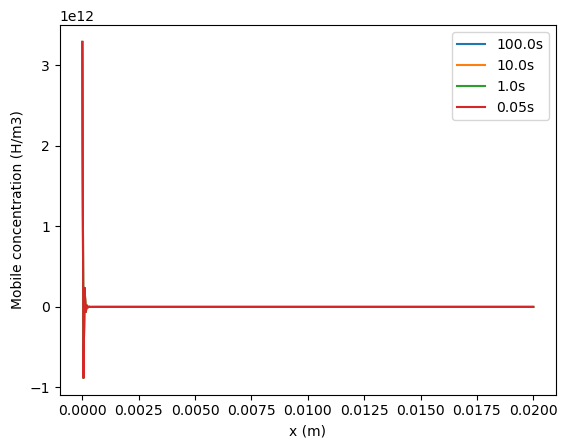

In [74]:
import matplotlib.pyplot as plt

data = np.genfromtxt(
    results_folder + "/mobile_concentration.txt", skip_header=1, delimiter=","
)

plt.plot(data[:, 0], data[:, 4], label=f"{float(times_input[3])}s")
plt.plot(data[:, 0], data[:, 3], label=f"{float(times_input[2])}s")
plt.plot(data[:, 0], data[:, 2], label=f"{float(times_input[1])}s")
plt.plot(data[:, 0], data[:, 1], label=f"{float(times_input[0])}s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()






# import matplotlib.pyplot as plt

# data = np.genfromtxt(
#     results_folder + "/mobile_concentration_steady.txt", skip_header=1, delimiter=","
# )

# plt.plot(data[:, 0], data[:, 1])
# plt.xlabel("x (m)")
# plt.ylabel("Mobile concentration (H/m3)")
# plt.show()